In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation , LSTM , Dropout , AveragePooling3D
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from lazypredict.Supervised import LazyClassifier

In [ ]:
df = pd.read_csv('data.csv')
# Getting only X part and removing target column
X = df.iloc[:,1:-1]

print("General info about colums,rows etc.")
df.info()
print("\nTarget variables value counts\n",df["y"].value_counts())

General info about colums,rows etc.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, column_a to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB

Target variables value counts
 4    2300
1    2300
5    2300
2    2300
3    2300
Name: y, dtype: int64


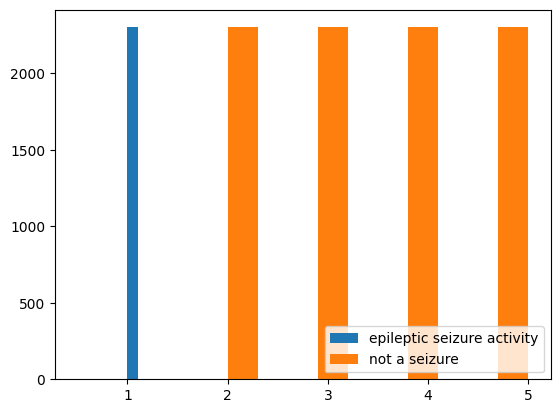

<bound method IndexOpsMixin.value_counts of 0        X21.V1.791
1        X15.V1.924
2           X8.V1.1
3         X16.V1.60
4         X20.V1.54
            ...    
11495    X22.V1.114
11496    X19.V1.354
11497      X8.V1.28
11498    X10.V1.932
11499    X16.V1.210
Name: column_a, Length: 11500, dtype: object>

In [ ]:
def hist(df,plt):
  plt.hist(df[df["y"]==1]["y"],label="epileptic seizure activity")
  plt.hist(df[df["y"]!=1]["y"],label="not a seizure")
  plt.legend(loc='lower right')
  plt.show()

hist(df,plt)

y = df.iloc[:,0]
df["column_a"].value_counts

In [ ]:
#This method drop the unnecessary column (Unnamed: 0) and transform the target variable
def prepareDataTime(df):
  df["y"]=[1 if df["y"][i]==1 else 0 for i in range(len(df["y"]))]
  target=df["y"]
  df_copy=df.drop(["column_a"],axis=1)
  return df_copy,target

df_time, target_time = prepareDataTime(df)
df_time.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x170,x171,x172,x173,x174,x175,x176,x177,x178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


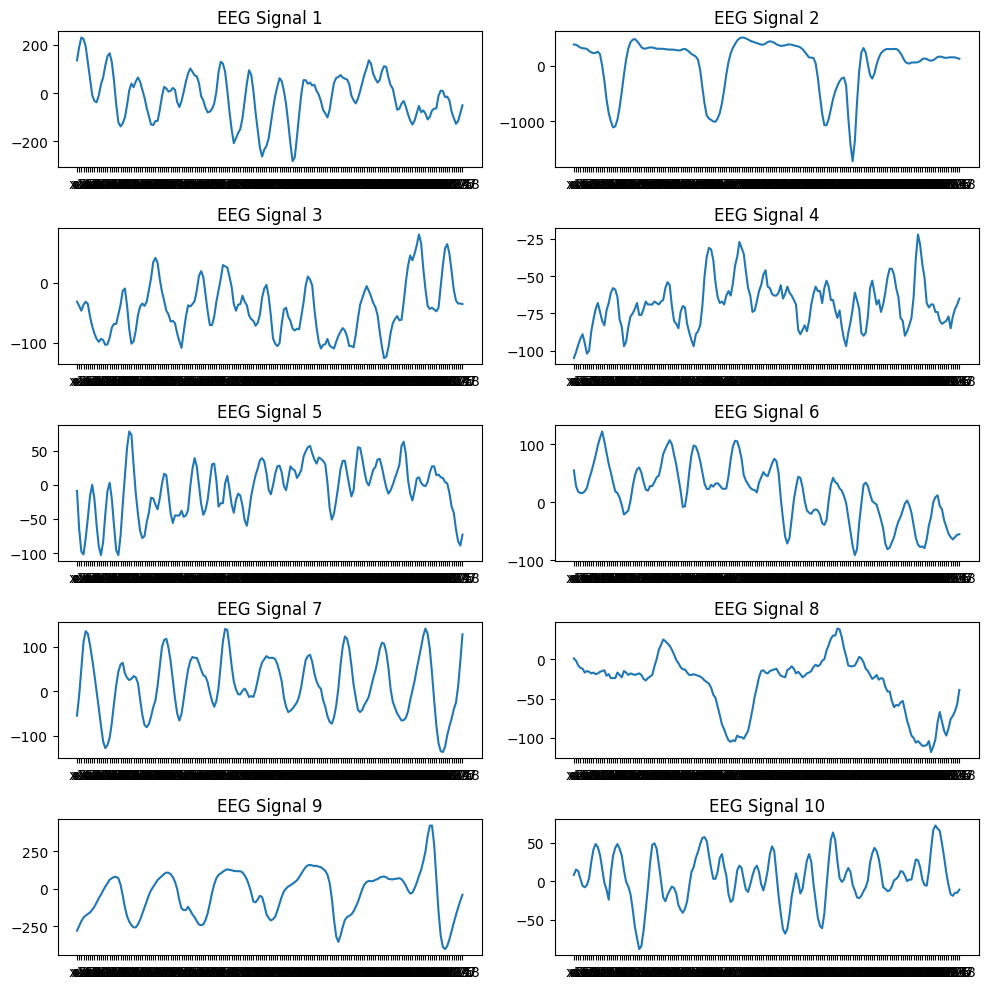

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.plot(df_time.iloc[i, :-1])
    ax.set_title('EEG Signal {}'.format(i+1))
plt.tight_layout()
plt.show()

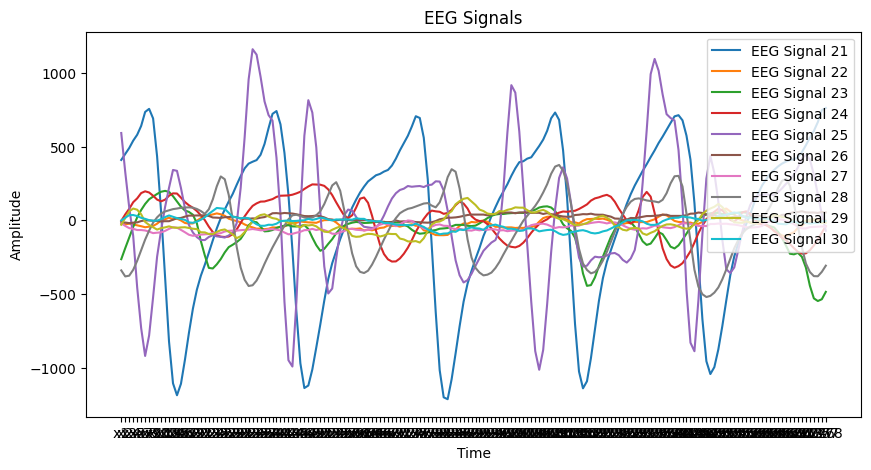

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

for i in range(10):
    ax.plot(df_time.iloc[i+20, :-1], label='EEG Signal {}'.format(i+20+1))

ax.legend(loc='upper right')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.set_title('EEG Signals')
plt.show()

0    4200
1    2300
Name: y, dtype: int64

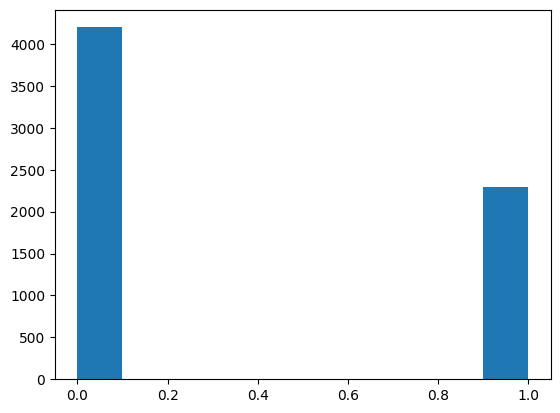

In [ ]:
def createBalancedDataset(data,random_state):
  #shuffling for random sampling
  X = shuffle(data,random_state=random_state)
  #getting first 6500 value
  return X.sort_values(by='y', ascending=False).iloc[:6500].index

v=createBalancedDataset(df_time,42)
plt.hist((df_time.iloc[v])['y'])
(df_time.iloc[v]['y']).value_counts() #more balanced dataset

In [ ]:
#normalizing dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_time.drop(['y'],axis=1))
n_df_fea=pd.DataFrame(scaler.transform(df_time.drop(['y'],axis=1)))

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X_trainr, X_testr, y_trainr, y_testr = train_test_split(n_df_fea.iloc[v], target_time.iloc[v], test_size=0.30, random_state=42)

In [ ]:
X_train_random_sampling, X_test_random_sampling, y_train_random_sampling, y_test_random_sampling = train_test_split(X_trainr, y_trainr, test_size=0.30, random_state=42)
print(X_train_random_sampling.shape, X_test_random_sampling.shape, y_train_random_sampling.shape, y_test_random_sampling.shape)

(3185, 178) (1365, 178) (3185,) (1365,)


In [ ]:
# This is done to just test the accuracy in case of SVM classifier
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

#I will explain this model in model part in the notebook
clf = svm.SVC(kernel="linear")
clf.fit(X_trainr, y_trainr)
#cross validation is 10
y_pred = cross_val_predict(clf,X_testr,y_testr,cv=10)
print("All features are inclueded\n",classification_report(y_testr, y_pred))

All features are inclueded
               precision    recall  f1-score   support

           0       0.67      1.00      0.80      1252
           1       0.98      0.11      0.20       698

    accuracy                           0.68      1950
   macro avg       0.82      0.56      0.50      1950
weighted avg       0.78      0.68      0.59      1950



Selecting most important 20 features with Random Forest

In [ ]:
#Firstly I used grid Search for getting best hyperparameter for random-forest
np.random.seed(42)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'max_depth': [2,5],
    'min_samples_split':[2,5,10],
    'n_estimators': [100,150],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_trainr, y_trainr)
print (CV_rfc.best_params_)

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42,max_depth=5,max_features='sqrt',min_samples_split=2,n_estimators=150)
clf.fit(X_trainr, y_trainr)
#I also get the importance rates and sort in a desending order and create a dataframe
zipped=pd.DataFrame(zip(X_trainr.columns,clf.feature_importances_),columns=["column","importance"]).sort_values(by="importance", ascending=False)
y_pred2 = cross_val_predict(clf,X_testr,y_testr,cv=10)
print("All featuares are included\n",classification_report(y_testr, y_pred2))

All featuares are included
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      1373
           1       0.97      0.84      0.90       772

    accuracy                           0.93      2145
   macro avg       0.94      0.91      0.92      2145
weighted avg       0.93      0.93      0.93      2145



In [ ]:
zipped.head(20) #The most important 20 values according to random forest

,column,importance
12,12,0.03
159,159,0.03
127,127,0.02
10,10,0.02
160,160,0.02
36,36,0.02
157,157,0.02
169,169,0.02
126,126,0.01
11,11,0.01


In [ ]:
#F-scores are decreased
clf = svm.SVC(kernel="linear")
clf.fit(X_trainr[zipped.iloc[:20].index], y_trainr)
y_pred = cross_val_predict(clf,X_testr[zipped.iloc[:20].index],y_testr,cv=10)
print("Only random forest's features are inclueded\n",classification_report(y_testr, y_pred))

Only random forest's features are inclueded
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1373
           1       0.91      0.01      0.03       772

    accuracy                           0.64      2145
   macro avg       0.78      0.51      0.40      2145
weighted avg       0.74      0.64      0.51      2145



Epoch 1/50
61/61 - 23s - loss: 0.6505 - accuracy: 0.6464 - val_loss: 0.6572 - val_accuracy: 0.6401 - 23s/epoch - 372ms/step
Epoch 2/50
61/61 - 6s - loss: 0.6488 - accuracy: 0.6491 - val_loss: 0.6570 - val_accuracy: 0.6401 - 6s/epoch - 97ms/step
Epoch 3/50
61/61 - 7s - loss: 0.6499 - accuracy: 0.6491 - val_loss: 0.6560 - val_accuracy: 0.6401 - 7s/epoch - 122ms/step
Epoch 4/50
61/61 - 6s - loss: 0.6490 - accuracy: 0.6491 - val_loss: 0.6564 - val_accuracy: 0.6401 - 6s/epoch - 101ms/step
Epoch 5/50
61/61 - 8s - loss: 0.6489 - accuracy: 0.6491 - val_loss: 0.6566 - val_accuracy: 0.6401 - 8s/epoch - 136ms/step
Epoch 6/50
61/61 - 6s - loss: 0.6487 - accuracy: 0.6491 - val_loss: 0.6565 - val_accuracy: 0.6401 - 6s/epoch - 104ms/step
Epoch 7/50
61/61 - 9s - loss: 0.6486 - accuracy: 0.6491 - val_loss: 0.6565 - val_accuracy: 0.6401 - 9s/epoch - 145ms/step
Epoch 8/50
61/61 - 6s - loss: 0.6486 - accuracy: 0.6491 - val_loss: 0.6561 - val_accuracy: 0.6401 - 6s/epoch - 103ms/step
Epoch 9/50
61/61 - 8s -

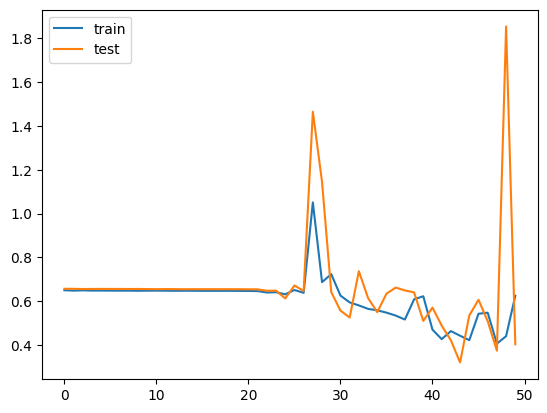

In [ ]:
# Tried LSTM implementation
#LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
# When i designed the network, Basically i used heuristic approach
X_trainrr=np.array(X_trainr).reshape(X_trainr.shape[0],X_trainr.shape[1],1)
X_testrr=np.array(X_testr).reshape(X_testr.shape[0],X_testr.shape[1],1)
model = Sequential()
model.add(LSTM(50, input_shape=(X_trainrr.shape[1], X_trainrr.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
# fit network
history = model.fit(X_trainrr, y_trainr, epochs=50, batch_size=72, validation_data=(X_testrr, y_testr), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
###################################################################################### Using Lazy predict classfier ########################################################################################333

In [ ]:

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_trainr, X_testr, y_trainr, y_testr)
models

100%|██████████| 29/29 [00:54<00:00,  1.88s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.97,0.96,0.96,0.97,2.58
ExtraTreesClassifier,0.97,0.96,0.96,0.97,1.27
RandomForestClassifier,0.96,0.96,0.96,0.96,6.33
XGBClassifier,0.96,0.95,0.95,0.96,7.32
SVC,0.96,0.95,0.95,0.96,0.72
BaggingClassifier,0.95,0.95,0.95,0.95,7.85
GaussianNB,0.95,0.93,0.93,0.95,0.06
AdaBoostClassifier,0.93,0.92,0.92,0.93,3.93
QuadraticDiscriminantAnalysis,0.91,0.90,0.90,0.91,0.19


In [ ]:
clf_random_sampling = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models_random_sampling,predictions_random_sampling = clf_random_sampling.fit(X_train_random_sampling, X_test_random_sampling, y_train_random_sampling, y_test_random_sampling)
models_random_sampling

100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.97,0.96,0.96,0.97,2.61
RandomForestClassifier,0.96,0.96,0.96,0.96,4.02
ExtraTreesClassifier,0.96,0.96,0.96,0.96,0.84
XGBClassifier,0.95,0.94,0.94,0.95,3.84
SVC,0.95,0.94,0.94,0.95,0.38
BaggingClassifier,0.95,0.94,0.94,0.95,4.78
GaussianNB,0.94,0.92,0.92,0.94,0.04
DecisionTreeClassifier,0.91,0.91,0.91,0.91,0.84
AdaBoostClassifier,0.92,0.90,0.90,0.92,2.68


In [ ]:
########################################################################### Trying out after doing feature extraction ################################################################

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42,max_depth=5,max_features='sqrt',min_samples_split=2,n_estimators=150)
clf.fit(X_trainr, y_trainr)
#I also get the importance rates and sort in a desending order and create a dataframe
zipped=pd.DataFrame(zip(X_trainr.columns,clf.feature_importances_),columns=["column","importance"]).sort_values(by="importance", ascending=False)

In [ ]:
X_trainr_FE = X_trainr[zipped.iloc[:,:20].index]
y_trainr_FE = y_trainr
X_testr_FE = X_testr[zipped.iloc[:,:20].index]
y_testr_FE = y_testr
##############################################################################
X_train_random_sampling_FE = X_train_random_sampling[zipped.iloc[:,:20].index]
y_train_random_sampling_FE = y_train_random_sampling
X_test_random_sampling_FE = X_test_random_sampling[zipped.iloc[:,:20].index]
y_test_random_sampling_FE = y_test_random_sampling

In [ ]:
y_trainr_FE.head()

7906    0
1927    0
8234    0
1630    0
5774    0
Name: y, dtype: int64

In [ ]:
clf_FE = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models_FE,predictions_FE = clf_FE.fit(X_trainr_FE, X_testr_FE, y_trainr_FE, y_testr_FE)
models_FE

100%|██████████| 29/29 [00:55<00:00,  1.91s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.97,0.97,0.97,0.97,7.04
LGBMClassifier,0.97,0.96,0.96,0.97,4.72
ExtraTreesClassifier,0.96,0.96,0.96,0.96,1.37
XGBClassifier,0.96,0.95,0.95,0.96,5.69
SVC,0.96,0.95,0.95,0.96,0.72
BaggingClassifier,0.95,0.95,0.95,0.95,7.33
GaussianNB,0.95,0.93,0.93,0.95,0.08
AdaBoostClassifier,0.93,0.92,0.92,0.93,4.50
ExtraTreeClassifier,0.92,0.91,0.91,0.92,0.06


In [ ]:
clf_random_sampling_FE = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models_random_sampling_FE,predictions_random_sampling_FE = clf_random_sampling_FE.fit(X_train_random_sampling_FE, X_test_random_sampling_FE, y_train_random_sampling_FE, y_test_random_sampling_FE)
models_random_sampling_FE

100%|██████████| 29/29 [00:38<00:00,  1.34s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.96,0.96,0.96,0.96,2.28
RandomForestClassifier,0.96,0.96,0.96,0.96,3.95
ExtraTreesClassifier,0.96,0.96,0.96,0.96,0.91
XGBClassifier,0.96,0.95,0.95,0.96,5.66
SVC,0.95,0.94,0.94,0.95,0.39
BaggingClassifier,0.95,0.94,0.94,0.95,4.53
GaussianNB,0.94,0.92,0.92,0.94,0.05
AdaBoostClassifier,0.92,0.90,0.90,0.92,2.68
DecisionTreeClassifier,0.91,0.90,0.90,0.91,0.91
